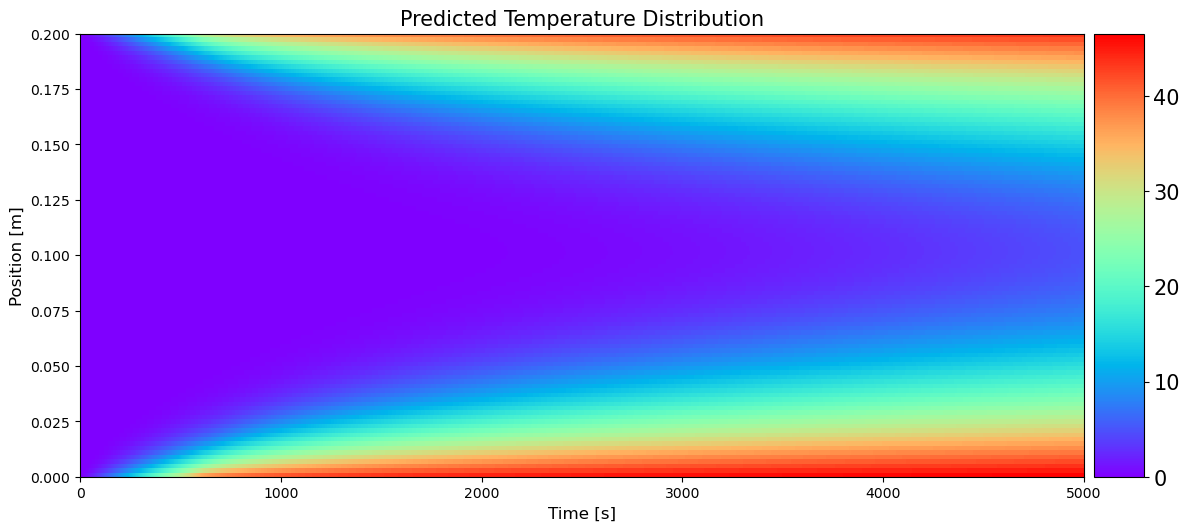

In [2]:
#3_HTEPINNs~.ipynbのコピー
import sys
sys.path.insert(0, './Utilities/')

import torch
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

np.random.seed(1234)

# CUDAのサポート
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

K = 0.47 #部品の熱伝導率。[W/mK]
rho = 1573 #部品の密度。[kg/m^3]
cp = 967 #部品の比熱。[J/kgK]
alpha = K / (rho * cp)

h1 = 100
h2 = 50

#TODO4：損失関数の重み付け
lambda_u, lambda_f, lambda_BC1, lambda_BC2 = 1.0, 1.0, 1.0, 1.0 

N_u = 100
N_f = 1000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# 最優先TODO：初期条件/境界条件の解を計算
x = np.linspace(0, 0.2, 100)[:, None]  # 空間グリッド
t = np.linspace(0, 5000, 1000)[:, None]  # 時間グリッド
dx = x[1] - x[0]  # 空間ステップ
dt = t[1] - t[0]  # 時間ステップ

Nx = len(x)
Nt = len(t)
u = np.zeros((Nt, Nx))

for n in range(0, Nt - 1):
    if t[n] <= 600:
        T_ext1 = T_ext2 = 0 + (50 - 0) * t[n] / 600
    else:
        T_ext1 = T_ext2 = 50
    for i in range(1, Nx - 1):
        u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2

    # 境界条件の適用
    # 左端の対流境界条件
    u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)

    # 右端の対流境界条件
    u[n + 1, -1] = (4 * u[n + 1, -2] - u[n + 1, -3] + 2 * dx * h2 / K * T_ext2) / (3 + 2 * dx * h2 / K)

# 温度分布の可視化
fig = plt.figure(figsize=(12, 10))  # 図のサイズを指定

# 予測温度分布
ax1 = fig.add_subplot(211)
h1 = ax1.imshow(u.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.10)
cbar1 = fig.colorbar(h1, cax=cax1)
cbar1.ax.tick_params(labelsize=15)
ax1.set_title('Exact Temperature Distribution', fontsize=15)
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_ylabel('Position [m]', fontsize=12)

plt.tight_layout()
plt.show()

X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = u.flatten()[:, None]

# ドメインの境界
lb = X_star.min(0)
ub = X_star.max(0)

# 初期条件と境界条件のデータを準備
xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
uu1 = u[0:1, :].T
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))
uu2 = u[:, 0:1]
xx3 = np.hstack((X[:, -1:], T[:, -1:]))
uu3 = u[:, -1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub - lb) * lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx, :]

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        self.depth = len(layers) - 1
        self.activation = torch.nn.ELU

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i + 1])))
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)

        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, k, rho, cp, alpha, h1, h2):
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)

        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        self.layers = layers
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.h1 = h1
        self.h2 = h2

        self.dnn = DNN(layers).to(device)
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr=1e-4)

        self.lambda_u = torch.tensor(lambda_u, requires_grad=True, device=device)
        self.lambda_f = torch.tensor(lambda_f, requires_grad=True, device=device)
        self.lambda_BC1 = torch.tensor(lambda_BC1, requires_grad=True, device=device)
        self.lambda_BC2 = torch.tensor(lambda_BC2, requires_grad=True, device=device)

    def net_t_inf(self, t):
        t_inf = torch.where(t <= 600, 50 * t / 600, torch.tensor(50.0).to(device))
        return t_inf

    def net_u(self, x, t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)
        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        f = self.alpha * u_xx - u_t
        return f

    def net_BC1(self, x, t):
        t_inf = self.net_t_inf(t)
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        BC1 = - (t_inf - u) + (self.k / self.h1) * u_x
        return BC1

    def net_BC2(self, x, t):
        t_inf = self.net_t_inf(t)
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        BC2 = t_inf - u - (self.k / self.h2) * u_x
        return BC2

    def loss_func(self):
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        x_BC1 = torch.full((self.t_f.shape[0], 1), self.lb[0], requires_grad=True).to(device)
        t_BC1 = self.t_f
        BC1_pred = self.net_BC1(x_BC1, t_BC1)

        x_BC2 = torch.full((self.t_f.shape[0], 1), self.ub[0], requires_grad=True).to(device)
        t_BC2 = self.t_f
        BC2_pred = self.net_BC2(x_BC2, t_BC2)

        loss_u = torch.mean((self.u - u_pred)**2)
        loss_f = torch.mean(f_pred**2)
        loss_BC1 = torch.mean(BC1_pred**2)
        loss_BC2 = torch.mean(BC2_pred**2)

        total_loss = (
            self.lambda_u * loss_u +
            self.lambda_f * loss_f +
            self.lambda_BC1 * loss_BC1 +
            self.lambda_BC2 * loss_BC2
        )

        return total_loss, loss_u, loss_f, loss_BC1, loss_BC2

    def train(self, nIter):
        for epoch in range(nIter):
            self.optimizer_Adam.zero_grad()
            total_loss, loss_u, loss_f, loss_BC1, loss_BC2 = self.loss_func()
            total_loss.backward()
            self.optimizer_Adam.step()

            with torch.no_grad():
                # Adaptive normalization
                self.lambda_u *= torch.exp(0.1 * loss_u.detach() / total_loss.detach())
                self.lambda_f *= torch.exp(0.1 * loss_f.detach() / total_loss.detach())
                self.lambda_BC1 *= torch.exp(0.1 * loss_BC1.detach() / total_loss.detach())
                self.lambda_BC2 *= torch.exp(0.1 * loss_BC2.detach() / total_loss.detach())

            if epoch % 100 == 0:
                # print(f'Epoch {epoch}: Total Loss: {total_loss:.4e}, Loss u: {loss_u:.4e}, Loss f: {loss_f:.4e}, Loss BC1: {loss_BC1:.4e}, Loss BC2: {loss_BC2:.4e}')
                #重みと損失の値を表示
                print(f'Epoch {epoch}: Total Loss: {total_loss.item():.4e}, Loss u: {loss_u.item():.4e}, Loss f: {loss_f.item():.4e}, Loss BC1: {loss_BC1.item():.4e}, Loss BC2: {loss_BC2.item():.4e}')
                print(f'lambda_u: {self.lambda_u.item()}, lambda_f: {self.lambda_f.item()}, lambda_BC1: {self.lambda_BC1.item()}, lambda_BC2: {self.lambda_BC2.item()}')

    def predict(self, X_star):
        x_star = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        t_star = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        u_star = self.net_u(x_star, t_star)
        f_star = self.net_f(x_star, t_star)

        return u_star.detach().cpu().numpy(), f_star.detach().cpu().numpy()

# モデルのインスタンス化
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha, rho, cp, K, h1, h2)

# モデルのトレーニング
model.train(1000)

# 予測
u_pred, f_pred = model.predict(X_star)

#消さない
# 誤差の計算
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(u - U_pred)

# 可視化
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4, 
    clip_on = False,
    alpha=1.0
)

# 誤差の計算
Error = np.abs(u - U_pred)

# 温度分布の可視化
fig = plt.figure(figsize=(12, 10))

# 予測温度分布
ax1 = fig.add_subplot(211)
h1 = ax1.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.10)
cbar1 = fig.colorbar(h1, cax=cax1)
cbar1.ax.tick_params(labelsize=15)
ax1.set_title('Predicted Temperature Distribution')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Position [m]')

# 残差の可視化
ax2 = fig.add_subplot(212)
h2 = ax2.imshow(Error.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.10)
cbar2 = fig.colorbar(h2, cax=cax2)
cbar2.ax.tick_params(labelsize=15)
ax2.set_title('Absolute Error Distribution')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Position [m]')

plt.tight_layout()
plt.show()